In [1]:
from IncentiveAllocation import (
    BinaryTreatmentPolicy as policy,
    BinaryTreatmentLearner as lerner,
    BinaryTreatmentEvaluator as evaluator,
    BinaryTreatmentOptimizer as optimizer,
)

In [2]:
from sklift.datasets import fetch_hillstrom

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
import matplotlib.pyplot as plt

In [4]:
data = fetch_hillstrom(target_col="spend")

In [5]:
t = 1 - (data["treatment"] == "No E-Mail").astype(int)
y = data["target"]
z = (data["target"] > 0).astype(int) * t
X = pd.DataFrame(OrdinalEncoder().fit_transform(data["data"]), columns=data["data"].columns)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 34120, number of used features: 8
[LightGBM] [Info] Start training from score 1.296985
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 17080, number of used features: 8
[LightGBM] [Info] Start training from score 0.708477
[LightGBM] [Info] Number of positive: 373, number of negative: 33747
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can se

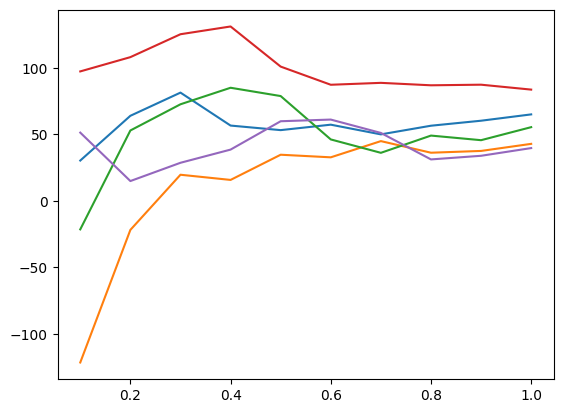

In [8]:
score_list = []
kf = KFold(n_splits=5, shuffle = True, random_state=0)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    z_train, z_test = z.iloc[train_index], z.iloc[test_index]
    t_train, t_test = t.iloc[train_index], t.iloc[test_index]

    revenue_model = LGBMRegressor()
    cost_model = LGBMClassifier()
    t_lerner = lerner.TLearner(revenue_model, cost_model)
    greedy_optimizer = optimizer.GreedyOptimizer()
    t_policy = policy.BinaryTreatmentPolicy(t_lerner, greedy_optimizer)
    t_policy.fit(X_train, y_train, z_train, t_train)

    aRoas = evaluator.AddonPerCost(t_policy, X_test, t_test, y_test, z_test)
    score = aRoas.score(30)
    score_list.append(score)

    budget_array, budget_rate_array, score_cuve = aRoas.score_curve(n_split=10, actual_cost=True)
    plt.plot(budget_rate_array, score_cuve)

plt.show()